# 3. FOSI 'The Blob'

### Import packages

In [2]:
import cmocean
import numpy as np
import xarray as xr
import pandas as pd
import cftime
import dask
import matplotlib.pyplot as plt
import os
import xesmf as xe
import pop_tools

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.animation import FFMpegWriter as fw
from matplotlib.animation import PillowWriter as pw

from IPython.utils import io
from os.path import exists

# Functions

In [3]:
# Calculate anomalies and remove a linear trend
def calculate_anomalies_trend_features(ds):
    sst = ds
    dyr = ds.time.dt.year + ds.time.dt.month/12
    # Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
    model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])
    
    # Take the pseudo-inverse of model to 'solve' least-squares problem
    pmodel = np.linalg.pinv(model)
    
    # Convert model and pmodel to xaray DataArray
    model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':sst.time.values, 'coeff':np.arange(1,7,1)}) 
    pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':sst.time.values})  
    
    # resulting coefficients of the model
    sst_mod = xr.DataArray(pmodel_da.dot(sst), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':sst.lat.values, 'lon':sst.lon.values})
    
    # Construct mean, trend, and seasonal cycle
    mean = model_da[:,0].dot(sst_mod[0,:,:])
    trend = model_da[:,1].dot(sst_mod[1,:,:])
    seas = model_da[:,2:].dot(sst_mod[2:,:,:])
    
    # compute anomalies by removing all  the model coefficients 
    ssta_notrend = sst-model_da.dot(sst_mod)
    
    # Use the 90th percentile as a threshold and find anomalies that exceed it. 
    if ssta_notrend.chunks:
        ssta_notrend = ssta_notrend.chunk({'time': -1})
    
    threshold = ssta_notrend.quantile(.9, dim=('time'))
    features_notrend = ssta_notrend.where(ssta_notrend>=threshold, other=np.nan)
    return mean, trend, seas, features_notrend, ssta_notrend

In [4]:
# Calculate anomalies by removing quadratic trend and seasonal cycle
def calculate_anomalies_quad_trend_features(ds):
    sst = ds
    dyr = ds.time.dt.year + ds.time.dt.month/12
    
    # Remove quadratic trend using polyfit - apply across lat/lon dimensions
    time_numeric = dyr - dyr.mean()  # Center for better numerical stability
    
    # Fit quadratic polynomial across spatial dimensions
    def fit_quadratic_trend(time_vals, data_vals):
        # Only fit if we have enough non-NaN data points
        if np.isnan(data_vals).all():
            return np.full_like(time_vals, np.nan)
        # Remove any NaN values for fitting
        mask = ~np.isnan(data_vals)
        if np.sum(mask) < 3:  # Need at least 3 points for quadratic fit
            return np.full_like(time_vals, np.nan)
        try:
            coeffs = np.polyfit(time_vals[mask], data_vals[mask], 2)
            return np.polyval(coeffs, time_vals)
        except:
            return np.full_like(time_vals, np.nan)
    
    # Apply the quadratic fit across all lat/lon points
    quadratic_trend = xr.apply_ufunc(
        fit_quadratic_trend,
        time_numeric, sst,
        input_core_dims=[['time'], ['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[sst.dtype]
    )
    
    # Remove quadratic trend
    sst_detrended = sst - quadratic_trend
    
    # Remove seasonal cycle (calculate and subtract monthly climatology)
    monthly_clim = sst_detrended.groupby('time.month').mean('time')
    seasonal_cycle = monthly_clim.sel(month=sst.time.dt.month)
    ssta = sst_detrended - seasonal_cycle
    
    # Use the 90th percentile as a threshold and find anomalies that exceed it
    if ssta.chunks:
        ssta = ssta.chunk({'time': -1})
    
    threshold = ssta.quantile(.9, dim=('time'))
    features = ssta.where(ssta >= threshold, other=np.nan)
    
    return quadratic_trend, seasonal_cycle, features, ssta

In [5]:
# Accessing glade CESM LENS2
def get_var_paths(directory, var):
    # Prefixes to match for future and historical datasets
    prefixes_to_match_fut = ['b.e21.BSSP370cmip6.', 'b.e21.BSSP370smbb.']
    prefixes_to_match_hist = ['b.e21.BHISTcmip6.', 'b.e21.BHISTsmbb.']
        
    # Sets to store unique prefixes for future and historical filenames
    prefixes_fut = list()
    prefixes_hist = list()
        
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        # Check and add prefixes for future scenario files
        if any(filename.startswith(prefix) for prefix in prefixes_to_match_fut) and filename.endswith('.nc'):
            prefixes_fut.append(filename.rsplit('.', 3)[0])
            
        # Check and add prefixes for historical scenario files
        if any(filename.startswith(prefix) for prefix in prefixes_to_match_hist) and filename.endswith('.nc'):
            prefixes_hist.append(filename.rsplit('.', 3)[0])
        
    prefixes_hist_set = set(prefixes_hist)
    sorted_unique_list_hist = sorted(prefixes_hist_set)
    
    prefixes_fut_set = set(prefixes_fut)
    sorted_unique_list_fut = sorted(prefixes_fut_set)
    
    path_intermed_fut = sorted_unique_list_fut
    path_intermed_hist = sorted_unique_list_hist

    return path_intermed_hist, path_intermed_fut

def get_ds_var(directory, var, comp, index_hist):
    path_intermed_hist, path_intermed_fut = get_var_paths(directory, var)
    filename_identifier = '.'.join(path_intermed_hist[index_hist].rsplit('.', 5)[1:4])
    index_fut = find_identifier_with_index(path_intermed_hist, filename_identifier)[0][1]
    hist_file_paths = get_hist_file_paths(var,directory, path_intermed_hist, index_hist)
    fut_file_paths = get_fut_file_paths(var, directory, path_intermed_fut, index_fut)
    ds_var_fut = file_path_to_var_ds(fut_file_paths)
    ds_var_hist = file_path_to_var_ds(hist_file_paths)
    return ds_var_hist, ds_var_fut

def find_identifier_with_index(prefixes, identifier):
    """
    Find prefixes that contain a specific identifier and their indices.

    Parameters:
        prefixes (list): A list of prefixes to search through.
        identifier (str): The identifier to search for in the prefixes.

    Returns:
        list: A list of tuples containing matching prefixes and their indices.
    """
    matching_prefixes_with_indices = []  # Initialize a list to store matches and their indices

    for index, prefix in enumerate(prefixes):  # Use enumerate to get both index and prefix
        if identifier in prefix:  # Check if the identifier is in the prefix
            matching_prefixes_with_indices.append((prefix, index))  # Add the prefix and index as a tuple

    return matching_prefixes_with_indices  # Return the list of matching prefixes and indices
    
def get_hist_file_paths(var, directory, path_intermed_hist, index):
    attrib_title = path_intermed_hist[index]
    file_paths = []
    for start_year in range(1850, 2010, 10):
        end_year = start_year + 9
        file_path = f'{directory}{attrib_title}.{var}.{start_year}01-{end_year}12.nc'
        file_paths.append(file_path)
    last_file_path = f'{directory}{attrib_title}.{var}.201001-201412.nc'
    file_paths.append(last_file_path)
    return file_paths

def get_fut_file_paths(var, directory, path_intermed_fut, index):
    attrib_title = path_intermed_fut[index]
    file_paths = []
    for start_year in range(2015, 2095, 10):
        end_year = start_year + 9
        file_path = f'{directory}{attrib_title}.{var}.{start_year}01-{end_year}12.nc'
        file_paths.append(file_path)
    last_file_path = f'{directory}{attrib_title}.{var}.209501-210012.nc'
    file_paths.append(last_file_path)
    return file_paths

def file_path_to_var_ds(file_paths):
    var_ds = xr.open_mfdataset(file_paths, 
                                 concat_dim='time', 
                                 combine='nested', 
                                 parallel=True)
    return var_ds

In [6]:
def setup_axes(ax):
    ax.add_feature(cfeature.LAND, facecolor='white', zorder=2)
    ax.coastlines(resolution='110m', color='black', lw=2)
    ax.set_ylabel('latitude')
    ax.set_xlabel('longitude')


def lons_to_360(data, coord='lon'):
    """ Converts longitude coordinates from (-180, 180) to (0, 360)."""
    data.coords[coord] = (360 + (data.coords[coord] % 360)) % 360
    data = data.sortby(data[coord])
    return data


def remove_trend(da, dim, deg=1):
    # detrend along a single dimension
    # return polyfit coefficients and detrended da
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    coord = da.coords[dim]
    fit = xr.polyval(coord, p.polyfit_coefficients)
    return da - fit


def get_anoms(da):
    clim = da.groupby('time.month').mean('time')
    da_noclim = da.groupby('time.month') - clim
    anoms = remove_trend(da_noclim, dim='time')
    return anoms


def regrid_SMYLE(ds, glat=1, glon=1):
    """
    Inputs:
        ds: xr.DataArray with coordinates that include TLAT and TLONG
    Returns:
        Regridded xr.DataArray with coordinates lat and lon
    """
    ds = ds.rename(({'TLONG': 'lon', 'TLAT': 'lat'}))
    ds_out = xe.util.grid_global(glon, glat)
    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)
    regridded = regridder(ds)
    new_coords = regridded.assign_coords({'y': regridded.lat[:, 0].values, 'x': regridded.lon[0].values})
    return new_coords.drop_vars(['lat', 'lon']).rename({'x': 'lon', 'y': 'lat'})

In [7]:
# Ocetrac methods
"""
This module applies all Ocetrac methods for labeling objects in 3 dimensions.
"""
import dask.array as dsa
import numpy as np
import scipy.ndimage
import xarray as xr

from skimage.measure import label as label_np
from skimage.measure import regionprops


def _apply_mask(binary_images, mask):
    binary_images_with_mask = binary_images.where(mask == 1, drop=False, other=0)
    return binary_images_with_mask


class Tracker:
    """
    Tracker object for applying Ocetrac
    """

    def __init__(
        self, da, mask, radius, min_size_quartile, timedim, xdim, ydim, positive=True
    ):
        self.da = da
        self.mask = mask
        self.radius = radius
        self.min_size_quartile = min_size_quartile
        self.timedim = timedim
        self.xdim = xdim
        self.ydim = ydim
        self.positive = positive

        if (timedim, ydim, xdim) != da.dims:
            try:
                da = da.transpose(timedim, ydim, xdim)
            except:
                raise ValueError(
                    f"Ocetrac currently only supports 3D DataArrays. The dimensions should only contain ({timedim}, {xdim}, and {ydim}). Found {list(da.dims)}"
                )

    def track(self):
        """
        Label and track image features.

        Parameters
        ----------
        da : xarray.DataArray
            The data to label.

        mask : xarray.DataArray
            The mask of points to ignore. Must be binary where 1 = true point and 0 = background to be ignored.

        radius : int
            The size of the structuring element used in morphological opening and closing. Radius specified by the number of grid units.
            
            Structuring elements are defined such that cells are included if their distance from the origin in index space is
            strictly less than the radius. For example, a radius of 1 means that the structuring element includes just an
            individual pixel (such that applying the morhological closing and opening just returns the original binary array),
            while a radius of 2 would additionally include the eight cells cells adjacent to the origin. As the radius increases,
            the shape of the structure element asymptotes to a circle centered on the origin.

        min_size_quartile : float
            The quantile used to define the threshold of the smallest area object retained in tracking. Value should be between 0 and 1.
            A value of exactly 0 means objects of any size are retained while a value of 1 retains just the single largest event.
            Higher values of `min_size_quartile` result in improved performance because less events are stored in memory and need to be
            compared.

        timedim : str
            The name of the time dimension

        xdim : str
            The name of the x dimension

        ydim : str
            The name of the y dimension

        positive : bool
            True if da values are expected to be positive, false if they are negative. Default argument is True

        Returns
        -------
        labels : xarray.DataArray
            Integer labels of the connected regions.
        """

        if (self.mask == 0).all():
            raise ValueError(
                "Found only zeros in `mask` input. The mask should indicate valid regions with values of 1"
            )

        # Convert data to binary, define structuring element, and perform morphological closing then opening
        binary_images = self._morphological_operations()

        # Apply mask
        binary_images_with_mask = _apply_mask(
            binary_images, self.mask
        )  # perhaps change to method? JB

        # Filter area
        area, min_area, binary_labels, N_initial = self._filter_area(
            binary_images_with_mask
        )

        # Label objects
        labels, num = self._label_either(binary_labels, return_num=True, connectivity=3)

        # Wrap labels
        grid_res = abs(self.da[self.xdim][1] - self.da[self.xdim][0])
        if self.da[self.xdim][-1] - self.da[self.xdim][0] >= 360 - grid_res:
            labels_wrapped, N_final = self._wrap(labels)
        else:
            labels_wrapped = labels
            N_final = np.max(labels)

        # Final labels to DataArray
        new_labels = xr.DataArray(
            labels_wrapped, dims=self.da.dims, coords=self.da.coords
        )
        new_labels = new_labels.where(new_labels != 0, drop=False, other=np.nan)

        ## Metadata

        # Calculate Percent of total object area retained after size filtering
        sum_tot_area = int(np.sum(area.values))

        reject_area = area.where(area <= min_area, drop=True)
        sum_reject_area = int(np.sum(reject_area.values))
        percent_area_reject = sum_reject_area / sum_tot_area

        accept_area = area.where(area > min_area, drop=True)
        sum_accept_area = int(np.sum(accept_area.values))
        percent_area_accept = sum_accept_area / sum_tot_area

        new_labels = new_labels.rename("labels")
        new_labels.attrs["initial objects identified"] = int(N_initial)
        new_labels.attrs["final objects tracked"] = int(N_final)
        new_labels.attrs["radius"] = self.radius
        new_labels.attrs["size quantile threshold"] = self.min_size_quartile
        new_labels.attrs["min area"] = min_area
        new_labels.attrs["percent area reject"] = percent_area_reject
        new_labels.attrs["percent area accept"] = percent_area_accept

        print("initial objects identified \t", int(N_initial))
        print("final objects tracked \t", int(N_final))

        return new_labels

    ### PRIVATE METHODS - not meant to be called by user ###

    def _morphological_operations(self):
        """Converts xarray.DataArray to binary, defines structuring element, and performs morphological closing then opening.
        Parameters
        ----------
        da     : xarray.DataArray
                The data to label
        radius : int
                Length of grid spacing that defines the radius of the structuring element used in morphological closing and opening.
                
                Structuring elements are defined such that cells are included if their distance from the origin in index space is
                strictly less than the radius. For example, a radius of 1 means that the structuring element includes just an
                individual pixel (such that applying the morhological closing and opening just returns the original binary array),
                while a radius of 2 would additionally include the eight cells cells adjacent to the origin. As the radius increases,
                the shape of the structure element asymptotes to a circle centered on the origin.

        """

        # Convert images to binary. All positive values == 1, otherwise == 0
        if self.positive == True:
            bitmap_binary = self.da.where(self.da > 0, drop=False, other=0)

        elif self.positive == False:
            bitmap_binary = self.da.where(self.da < 0, drop=False, other=0)

        bitmap_binary = bitmap_binary.where(bitmap_binary == 0, drop=False, other=1)

        # Define structuring element
        diameter = self.radius * 2
        x = np.arange(-self.radius, self.radius + 1)
        x, y = np.meshgrid(x, x)
        r = x**2 + y**2
        se = r < self.radius**2

        def binary_open_close(bitmap_binary):
            bitmap_binary_padded = np.pad(
                bitmap_binary, ((diameter, diameter), (diameter, diameter)), mode="wrap"
            )
            # If the radius is equal to 1, the structuring element is just an individual pixel, so
            # it is faster to just skip the calls to `binary_closing` and `binary_opening`
            if self.radius == 1:
                s2 = bitmap_binary_padded
            elif self.radius > 1:
                s1 = scipy.ndimage.binary_closing(bitmap_binary_padded, se, iterations=1)
                s2 = scipy.ndimage.binary_opening(s1, se, iterations=1)
            else:
                raise ValueError("radius must be an integer greater than or equal to 1")
                
            unpadded = s2[diameter:-diameter, diameter:-diameter]
            return unpadded

        mo_binary = xr.apply_ufunc(
            binary_open_close,
            bitmap_binary,
            input_core_dims=[[self.ydim, self.xdim]],
            output_core_dims=[[self.ydim, self.xdim]],
            output_dtypes=[bitmap_binary.dtype],
            vectorize=True,
            dask="parallelized",
        )
        return mo_binary

    def _filter_area(self, binary_images):
        """calculatre area with regionprops"""

        def get_labels(binary_images):
            blobs_labels = self._label_either(binary_images, background=0)
            return blobs_labels

        labels = xr.apply_ufunc(
            get_labels,
            binary_images,
            input_core_dims=[[self.ydim, self.xdim]],
            output_core_dims=[[self.ydim, self.xdim]],
            output_dtypes=[binary_images.dtype],
            vectorize=True,
            dask="parallelized",
        )

        labels = xr.DataArray(
            labels, dims=binary_images.dims, coords=binary_images.coords
        )
        labels = labels.where(labels > 0, drop=False, other=np.nan)

        # The labels are repeated each time step, therefore we relabel them to be consecutive
        max_id = 0
        for i in range(1, labels.shape[0]):
            max_id = np.nanmax([max_id, labels[i - 1, :, :].max().values])
            labels[i, :, :] = labels[i, :, :].values + max_id

        labels = labels.where(labels > 0, drop=False, other=0)
        labels_wrapped, N_initial = self._wrap(np.array(labels))

        # Calculate Area of each object and keep objects larger than threshold
        props = regionprops(labels_wrapped.astype("int"))

        labelprops = [p.label for p in props]
        labelprops = xr.DataArray(
            labelprops, dims=["label"], coords={"label": labelprops}
        )

        area = xr.DataArray(
            [p.area for p in props], dims=["label"], coords={"label": labelprops}
        )  # Number of pixels of the region.

        if area.size == 0:
            raise ValueError(
                f"No objects were detected. Try changing radius or min_size_quartile parameters."
            )

        min_area = np.percentile(area, self.min_size_quartile * 100)
        print(f"minimum area: {min_area}")

        keep_labels = labelprops.where(area >= min_area, drop=True)
        keep_where = np.isin(labels_wrapped, keep_labels)
        out_labels = xr.DataArray(
            np.where(keep_where == False, 0, labels_wrapped),
            dims=binary_images.dims,
            coords=binary_images.coords,
        )

        # Convert images to binary. All positive values == 1, otherwise == 0
        binary_labels = out_labels.where(out_labels == 0, drop=False, other=1)

        return area, min_area, binary_labels, N_initial

    def _label_either(self, data, **kwargs):
        if isinstance(data, dsa.Array):
            try:
                from dask_image.ndmeasure import label as label_dask

                def label_func(a, **kwargs):
                    ids, num = label_dask(a, **kwargs)
                    return ids

            except ImportError:
                raise ImportError(
                    "Dask_image is required to use this function on Dask arrays. "
                    "Either install dask_image or else call .load() on your data."
                )
        else:
            label_func = label_np
        return label_func(data, **kwargs)

    def _wrap(self, labels):
        """Impose periodic boundary and wrap labels"""
        first_column = labels[..., 0]
        last_column = labels[..., -1]

        unique_first = np.unique(first_column[first_column > 0])

        # This loop iterates over the unique values in the first column, finds the location of those values in
        # the first columnm and then uses that index to replace the values in the last column with the first column value
        for i in enumerate(unique_first):
            first = np.where(first_column == i[1])
            last = last_column[first[0], first[1]]
            bad_labels = np.unique(last[last > 0])
            replace = np.isin(labels, bad_labels)
            labels[replace] = i[1]

        labels_wrapped = np.unique(labels, return_inverse=True)[1].reshape(labels.shape)

        # recalculate the total number of labels
        N = np.max(labels_wrapped)

        return labels_wrapped, N

In [8]:
# Ocetrac methods
import dask.array as dsa
import numpy as np
import scipy.ndimage
import xarray as xr

from skimage.measure import label as label_np
from skimage.measure import regionprops

def _apply_mask(binary_images, mask):
    binary_images_with_mask = binary_images.where(mask == 1, drop=False, other=0)
    return binary_images_with_mask


class Tracker:
    """
    Tracker object for applying Ocetrac
    """
    def __init__(
        self, da, mask, radius, min_size_quartile, timedim, xdim, ydim, positive=True
    ):
        self.da = da
        self.mask = mask
        self.radius = radius
        self.min_size_quartile = min_size_quartile
        self.timedim = timedim
        self.xdim = xdim
        self.ydim = ydim
        self.positive = positive

        if (timedim, ydim, xdim) != da.dims:
            try:
                da = da.transpose(timedim, ydim, xdim)
            except:
                raise ValueError(
                    f"Ocetrac currently only supports 3D DataArrays. The dimensions should only contain ({timedim}, {xdim}, and {ydim}). Found {list(da.dims)}"
                )


    def track(self):
        if (self.mask == 0).all():
            raise ValueError(
                "Found only zeros in `mask` input. The mask should indicate valid regions with values of 1"
            )


        # Convert data to binary, define structuring element, and perform morphological closing then opening
        binary_images = self._morphological_operations()


        # Apply mask
        binary_images_with_mask = _apply_mask(
            binary_images, self.mask
        )  # perhaps change to method? JB


        # Filter area
        area, min_area, binary_labels, N_initial = self._filter_area(
            binary_images_with_mask
        )

        # Label objects
        labels, num = self._label_either(binary_labels, return_num=True, connectivity=3)


        # Wrap labels
        grid_res = abs(self.da[self.xdim][1] - self.da[self.xdim][0])
        if self.da[self.xdim][-1] - self.da[self.xdim][0] >= 360 - grid_res:
            labels_wrapped, N_final = self._wrap(labels)
        else:
            labels_wrapped = labels
            N_final = np.max(labels)


        # Final labels to DataArray
        new_labels = xr.DataArray(
            labels_wrapped, dims=self.da.dims, coords=self.da.coords
        )
        new_labels = new_labels.where(new_labels != 0, drop=False, other=np.nan)


        ## Metadata


        # Calculate Percent of total object area retained after size filtering
        sum_tot_area = int(np.sum(area.values))


        reject_area = area.where(area <= min_area, drop=True)
        sum_reject_area = int(np.sum(reject_area.values))
        percent_area_reject = sum_reject_area / sum_tot_area


        accept_area = area.where(area > min_area, drop=True)
        sum_accept_area = int(np.sum(accept_area.values))
        percent_area_accept = sum_accept_area / sum_tot_area


        new_labels = new_labels.rename("labels")
        new_labels.attrs["initial objects identified"] = int(N_initial)
        new_labels.attrs["final objects tracked"] = int(N_final)
        new_labels.attrs["radius"] = self.radius
        new_labels.attrs["size quantile threshold"] = self.min_size_quartile
        new_labels.attrs["min area"] = min_area
        new_labels.attrs["percent area reject"] = percent_area_reject
        new_labels.attrs["percent area accept"] = percent_area_accept


        print("initial objects identified \t", int(N_initial))
        print("final objects tracked \t", int(N_final))


        return new_labels

    def _morphological_operations(self):
        # Convert images to binary. All positive values == 1, otherwise == 0
        if self.positive == True:
            bitmap_binary = self.da.where(self.da > 0, drop=False, other=0)


        elif self.positive == False:
            bitmap_binary = self.da.where(self.da < 0, drop=False, other=0)


        bitmap_binary = bitmap_binary.where(bitmap_binary == 0, drop=False, other=1)

        # Define structuring element
        diameter = self.radius * 2
        x = np.arange(-self.radius, self.radius + 1)
        x, y = np.meshgrid(x, x)
        r = x**2 + y**2
        se = r < self.radius**2


        def binary_open_close(bitmap_binary):
            bitmap_binary_padded = np.pad(
                bitmap_binary, ((diameter, diameter), (diameter, diameter)), mode="wrap"
            )
            # If the radius is equal to 1, the structuring element is just an individual pixel, so
            # it is faster to just skip the calls to `binary_closing` and `binary_opening`
            if self.radius == 1:
                s2 = bitmap_binary_padded
            elif self.radius > 1:
                s1 = scipy.ndimage.binary_closing(bitmap_binary_padded, se, iterations=1)
                s2 = scipy.ndimage.binary_opening(s1, se, iterations=1)
            else:
                raise ValueError("radius must be an integer greater than or equal to 1")
                
            unpadded = s2[diameter:-diameter, diameter:-diameter]
            return unpadded


        mo_binary = xr.apply_ufunc(
            binary_open_close,
            bitmap_binary,
            input_core_dims=[[self.ydim, self.xdim]],
            output_core_dims=[[self.ydim, self.xdim]],
            output_dtypes=[bitmap_binary.dtype],
            vectorize=True,
            dask="parallelized",
        )
        return mo_binary


    def _filter_area(self, binary_images):
        def get_labels(binary_images):
            blobs_labels = self._label_either(binary_images, background=0)
            return blobs_labels


        labels = xr.apply_ufunc(
            get_labels,
            binary_images,
            input_core_dims=[[self.ydim, self.xdim]],
            output_core_dims=[[self.ydim, self.xdim]],
            output_dtypes=[binary_images.dtype],
            vectorize=True,
            dask="parallelized",
        )


        labels = xr.DataArray(
            labels, dims=binary_images.dims, coords=binary_images.coords
        )
        labels = labels.where(labels > 0, drop=False, other=np.nan)


        # The labels are repeated each time step, therefore we relabel them to be consecutive
        max_id = 0
        for i in range(1, labels.shape[0]):
            max_id = np.nanmax([max_id, labels[i - 1, :, :].max().values])
            labels[i, :, :] = labels[i, :, :].values + max_id


        labels = labels.where(labels > 0, drop=False, other=0)
        labels_wrapped, N_initial = self._wrap(np.array(labels))


        # Calculate Area of each object and keep objects larger than threshold
        props = regionprops(labels_wrapped.astype("int"))


        labelprops = [p.label for p in props]
        labelprops = xr.DataArray(
            labelprops, dims=["label"], coords={"label": labelprops}
       )


        area = xr.DataArray(
            [p.area for p in props], dims=["label"], coords={"label": labelprops}
        )  # Number of pixels of the region.


        if area.size == 0:
            raise ValueError(
                f"No objects were detected. Try changing radius or min_size_quartile parameters."
            )


        min_area = np.percentile(area, self.min_size_quartile * 100)
        print(f"minimum area: {min_area}")


        keep_labels = labelprops.where(area >= min_area, drop=True)
        keep_where = np.isin(labels_wrapped, keep_labels)
        out_labels = xr.DataArray(
            np.where(keep_where == False, 0, labels_wrapped),
            dims=binary_images.dims,
            coords=binary_images.coords,
        )


        # Convert images to binary. All positive values == 1, otherwise == 0
        binary_labels = out_labels.where(out_labels == 0, drop=False, other=1)


        return area, min_area, binary_labels, N_initial


    def _label_either(self, data, **kwargs):
        if isinstance(data, dsa.Array):
            try:
                from dask_image.ndmeasure import label as label_dask


                def label_func(a, **kwargs):
                    ids, num = label_dask(a, **kwargs)
                    return ids


            except ImportError:
               raise ImportError(
                    "Dask_image is required to use this function on Dask arrays. "
                    "Either install dask_image or else call .load() on your data."
                )
        else:
            label_func = label_np
        return label_func(data, **kwargs)


    def _wrap(self, labels):
        """Impose periodic boundary and wrap labels"""
        first_column = labels[..., 0]
        last_column = labels[..., -1]


        unique_first = np.unique(first_column[first_column > 0])


        # This loop iterates over the unique values in the first column, finds the location of those values in
        # the first columnm and then uses that index to replace the values in the last column with the first column value
        for i in enumerate(unique_first):
            first = np.where(first_column == i[1])
            last = last_column[first[0], first[1]]
            bad_labels = np.unique(last[last > 0])
            replace = np.isin(labels, bad_labels)
            labels[replace] = i[1]


        labels_wrapped = np.unique(labels, return_inverse=True)[1].reshape(labels.shape)


        # recalculate the total number of labels
        N = np.max(labels_wrapped)


        return labels_wrapped, N

# Load data

In [10]:
#### CESM LENS2
var = 'SST'
comp = 'atm'
directory = f'/glade/campaign/cgd/cesm/CESM2-LE/{comp}/proc/tseries/month_1/{var}/'
ens_memb_index = 0
ds_var_hist_SST, ds_var_fut_SST = get_ds_var(directory, 'SST','atm', ens_memb_index) 

# selecting our observational time period overlap with ERA5 (1979 to 2022)
CESMLENS_SST_hist_time_slice = ds_var_hist_SST.SST.sel(time=slice('1979-01-01', '2015-01-01'))
    
CESMLENS_SST_fut_time_slice = ds_var_fut_SST.SST.sel(time=slice('2015-02-01', '2020-12-01'))

CESMLENS_SST_ds = xr.concat([CESMLENS_SST_hist_time_slice, CESMLENS_SST_fut_time_slice], dim='time')
CESMLENS_SST = CESMLENS_SST_ds.compute()

In [11]:
#### FOSI
firstyear = 1979
lastyear = 2020
field = 'TEMP'

# Mask the Arctic, the Baltic Sea, the Red Sea, and the Black Sea
grid = pop_tools.get_grid('POP_gx1v7')
mask = xr.where((grid['REGION_MASK']>0) & (grid['REGION_MASK']<9), 1, np.nan)

fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
ds_smyle_fosi = xr.open_dataset(fpath+fname)[field].isel(z_t=0)

fosi_montime_vals = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)]
ds_smyle_fosi['time'] = fosi_montime_vals
fosi_temp = ds_smyle_fosi[ds_smyle_fosi.time['time.year'].isin(list(range(firstyear, lastyear+1)))].where(mask==1, np.nan)

fosi_anom_1deg_wzeros = regrid_SMYLE(ds_smyle_fosi)
fosi_anom_1deg = fosi_anom_1deg_wzeros.where(fosi_anom_1deg_wzeros!=0, np.nan)

regridder = xe.Regridder(fosi_anom_1deg.sel(time=slice('1979-01-01','2021-01-01')), CESMLENS_SST[:,:,:], 'nearest_s2d', periodic=True)
regridded = regridder(fosi_anom_1deg.sel(time=slice('1979-01-01','2021-01-01')))
# regridded[4,:,:].plot.contourf(levels=25)

In [12]:
dyr = regridded.time.dt.year + regridded.time.dt.month/12

In [ ]:
# fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
# fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
# ds_smyle_fosi = xr.open_dataset(fpath+fname)[field]#

## Mean, trend, seasonality, features_notrend, ssta_notrend

In [14]:
mean, trend, seas, features_notrend, ssta_notrend = calculate_anomalies_trend_features(
    regridded)

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [187]:
quadratic_trend, seasonal_cycle, features_notrend, ssta_notrend = calculate_anomalies_quad_trend_features(
    regridded)

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [188]:
mask_1deg = ~np.isnan(regridded.isel(time=0))
# mask_1deg[:,:].plot.contourf(levels=25)

In [189]:
# defining our region (North Pacific Ocean)
upper_lat = 65
lower_lat = 5
left_lon = 150
right_lon = 250

In [20]:
regridded_features_no_trend_NEP = features_notrend.sel(lon=slice(left_lon, right_lon), lat=slice(lower_lat,upper_lat))
regridded_ssta_no_trend_NEP = ssta_notrend.sel(lon=slice(left_lon, right_lon), lat=slice(lower_lat,upper_lat))
mask_1deg_NEP = mask_1deg.sel(lon=slice(left_lon, right_lon), lat=slice(lower_lat,upper_lat))

In [190]:
regridded_features_no_trend_NEP = features_notrend.sel(lon=slice(left_lon, right_lon), lat=slice(lower_lat,upper_lat))
regridded_ssta_no_trend_NEP = ssta_notrend.sel(lon=slice(left_lon, right_lon), lat=slice(lower_lat,upper_lat))
mask_1deg_NEP = mask_1deg.sel(lon=slice(left_lon, right_lon), lat=slice(lower_lat,upper_lat))

# Applying Ocetrac to FOSI

In [66]:
full_mask_land = regridded_features_no_trend_NEP
full_masked = full_mask_land.where(full_mask_land != 0)
binary_out_afterlandmask=np.isfinite(full_masked)
# # newmask = np.isfinite(da[:,:,:][:])
newmask = mask_1deg_NEP
    
binary_out_afterlandmask = binary_out_afterlandmask.compute()
newmask = newmask.compute()

In [114]:
obj_Tracker = Tracker(binary_out_afterlandmask[:,:,:], #binary_out_afterlandmask.SST[:,:,:], binary_out_afterlandmask[:,:,:], 
                                  newmask, 
                                  radius=2, #typically 3
                                  min_size_quartile= 0.75, # check these values
                                  timedim = 'time', 
                                  xdim = 'lon', 
                                  ydim='lat', 
                                  positive=True)

In [115]:
blobs = obj_Tracker.track()

minimum area: 204.0
initial objects identified 	 1365
final objects tracked 	 112


In [ ]:
blobs.attrs
mo = obj_Tracker._morphological_operations()

# Analysis and Plotting

In [13]:
# blobs = xr.open_dataset('fosi_blobs.nc').labels
# FOSI 
## Linear detrend 2°
## The Blob is ID 94
fosi_blobs_r2 = xr.open_dataset('fosi_blobs_r2.nc') # 112 final events

## Quadratic detrend 2°
## The Blob is ID 79
fosi_blobs_r2_quad = xr.open_dataset('fosi_blobs_r3_quad.nc') # 113 final events

## Linear detrend 3°
## The Blob is ID 83
fosi_blobs_r3 = xr.open_dataset('fosi_blobs_r3.nc') # 97 final events

## Quadratic detrend 3°
## The Blob is ID 79
fosi_blobs_r3_quad = xr.open_dataset('fosi_blobs_r3_quad.nc') # 89 final events

## Quadratic detrended Blob

In [185]:
object_id = 79. # for 2 # only lasts 12 months
blobs = fosi_blobs_r2_quad
object_count_per_time = (blobs == object_id).sum(dim=['lat', 'lon'])
true_time_steps = object_count_per_time.time.where(object_count_per_time > 0, drop=True)
# print(len(true_time_steps))
# print(true_time_steps)
only_ts = regridded_ssta_no_trend_NEP.sel(time=true_time_steps.time)
one_obj = blobs.sel(time=true_time_steps.time)
blobs_nan = xr.where(one_obj == object_id, 1., 0.)

In [161]:
time_ls = []
for object_id in np.unique(blobs.labels)[:-1]:
    object_count_per_time = (blobs == object_id).sum(dim=['lat', 'lon'])
    true_time_steps = object_count_per_time.time.where(object_count_per_time > 0, drop=True)
    # print(len(true_time_steps))
    # print(true_time_steps)
    only_ts = regridded_ssta_no_trend_NEP.sel(time=true_time_steps.time)
    one_obj = blobs.sel(time=true_time_steps.time)
    blobs_nan = xr.where(one_obj == object_id, 1., 0.)
    time_ls.append(len(blobs_nan.time))

np.argsort(time_ls)

In [196]:
np.argsort(time_ls)

array([88, 74, 75, 79,  0, 68, 69, 70, 72, 17, 18, 19, 22, 23, 58, 59, 60,
       61, 63, 64, 52, 54, 55, 56, 41, 44, 46, 47, 33, 39, 40,  1,  3,  6,
       81, 82, 83, 84, 85, 87,  2, 34, 20, 62, 26, 27, 51, 50,  9, 10, 16,
       15, 77, 67, 57, 53, 13, 73,  8, 86,  5, 45, 66, 14, 38, 35, 25, 32,
       36,  7, 80, 48, 71, 12, 76, 29, 31, 65, 21,  4, 24, 37, 42, 28, 11,
       49, 30, 43, 78])

In [191]:
one_obj_ssta = regridded_ssta_no_trend_NEP.sel(time=true_time_steps.time)*blobs_nan

In [194]:
len(blobs_nan.time)

12

In [192]:
dates = one_obj_ssta.time.data

2014-12-15 00:00:00


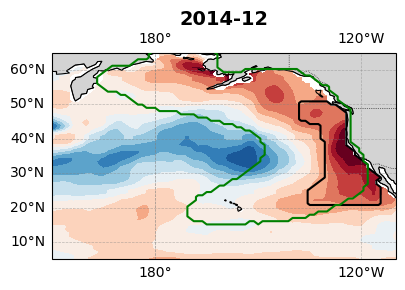

2015-01-15 00:00:00


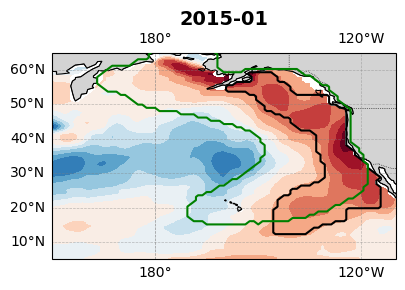

2015-02-15 00:00:00


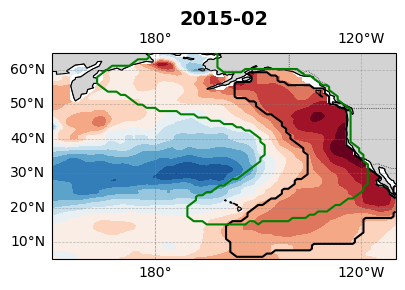

2015-03-15 00:00:00


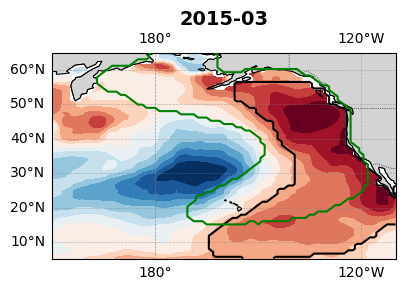

2015-04-15 00:00:00


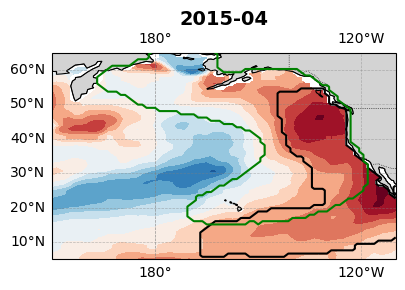

2015-05-15 00:00:00


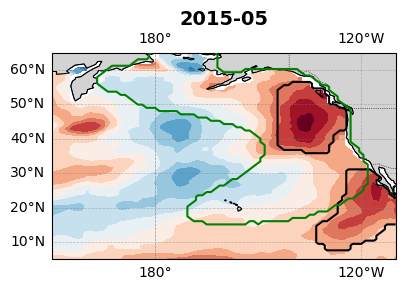

2015-06-15 00:00:00


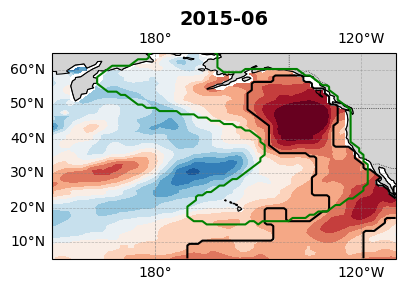

2015-07-15 00:00:00


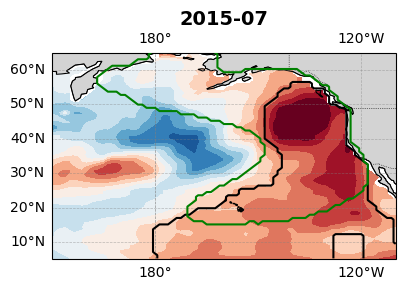

2015-08-15 00:00:00


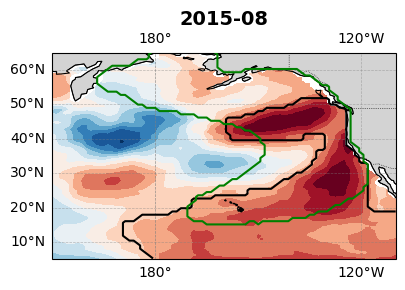

2015-09-15 00:00:00


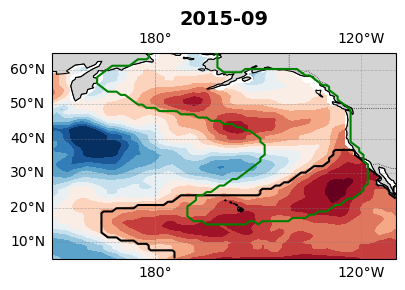

2015-10-15 00:00:00


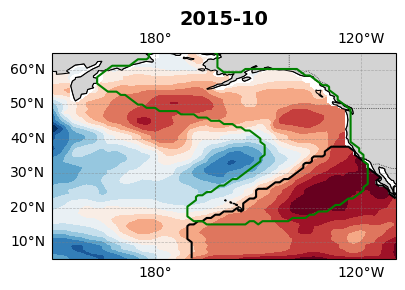

2015-11-15 00:00:00


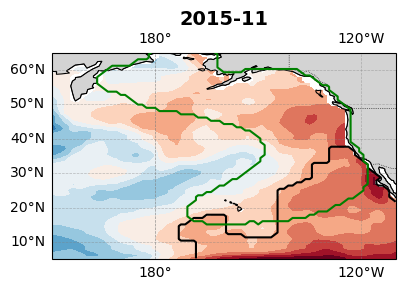

In [195]:
for i in range(len(blobs_nan.time)):
    print(dates[i])
    #######
    fig = plt.figure(figsize=(5, 3))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    im = regridded_ssta_no_trend_NEP.sel(time=dates[i]).plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=-1.5, vmax=1.5,
        levels=np.linspace(-1.5, 1.5, 13),
        cmap='RdBu_r',
        extend='both',
        add_colorbar=False
    )
    
    blobs_nan.labels[i,:,:].plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=[0.5],
            colors='k',
            linewidths=1.5,
            zorder=20
        )
    
    blob_mask.plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=[0.5],
            colors='green',
            linewidths=1.5,
            zorder=20
        )
    
    # cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, aspect=30)
    # cbar.set_label('SST Anomaly (°C)', fontsize=12)
    # cbar.ax.tick_params(labelsize=10)
    date_str = pd.to_datetime(str(dates[i])).strftime('%Y-%m')
    ax.set_title(date_str, 
                 fontsize=14, fontweight='bold', pad=5)
    ax.set_extent([150, 250, 5, 65], crs=ccrs.PlateCarree())
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True  # Ensure bottom labels are on
    
    plt.tight_layout()
    plt.show()

## Linear detrended Blob

In [22]:
object_id = 94. # for 2
blobs = fosi_blobs_r2
object_count_per_time = (blobs == object_id).sum(dim=['lat', 'lon'])
true_time_steps = object_count_per_time.time.where(object_count_per_time > 0, drop=True)
# print(len(true_time_steps))
# print(true_time_steps)
only_ts = regridded_ssta_no_trend_NEP.sel(time=true_time_steps.time)
one_obj = blobs.sel(time=true_time_steps.time)
blobs_nan = xr.where(one_obj == object_id, 1., 0.)

In [73]:
mask_3 = xr.open_dataset('mean_mask_3.nc').mhw_obj
mask_3 = xr.where(mask_3 > 0.1, 1, 0)
blob_mask_nan = mask_3
blob_mask = mask_3

In [135]:
# object_id = 455. # 
# object_count_per_time = (blobs == object_id).sum(dim=['lat', 'lon'])
# true_time_steps = object_count_per_time.time.where(object_count_per_time > 0, drop=True)
# # print(len(true_time_steps))
# # print(true_time_steps)
# only_ts = regridded_ssta_no_trend_NEP.sel(time=true_time_steps.time)
# one_obj = blobs.sel(time=true_time_steps.time)
# blobs_nan = xr.where(one_obj == object_id, 1., 0.)
# # plt.figure(figsize=(3, 1.5))
# # one_obj[:,:,:].sum(dim='time').plot.contourf()

In [24]:
one_obj_ssta = regridded_ssta_no_trend_NEP.sel(time=true_time_steps.time)*blobs_nan

In [25]:
dates = one_obj_ssta.time.data

In [143]:
i = 19

In [144]:
print(dates[i])

2015-12-15 00:00:00


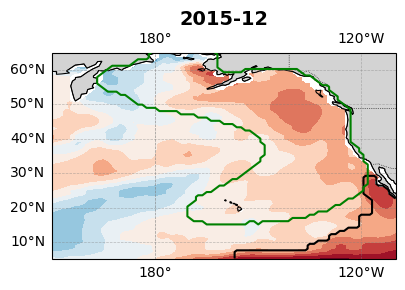

In [145]:
fig = plt.figure(figsize=(5, 3))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
im = regridded_ssta_no_trend_NEP.sel(time=dates[i]).plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=-1.5, vmax=1.5,
    levels=np.linspace(-1.5, 1.5, 13),
    cmap='RdBu_r',
    extend='both',
    add_colorbar=False
)

blobs_nan.labels[i,:,:].plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=[0.5],
        colors='k',
        linewidths=1.5,
        zorder=20
    )

blob_mask.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=[0.5],
        colors='green',
        linewidths=1.5,
        zorder=20
    )

# cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, aspect=30)
# cbar.set_label('SST Anomaly (°C)', fontsize=12)
# cbar.ax.tick_params(labelsize=10)
date_str = pd.to_datetime(str(dates[i])).strftime('%Y-%m')
ax.set_title(date_str, 
             fontsize=14, fontweight='bold', pad=5)
ax.set_extent([150, 250, 5, 65], crs=ccrs.PlateCarree())
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True  # Ensure bottom labels are on

plt.tight_layout()
plt.show()